<a href="https://colab.research.google.com/github/RoshanJamthe/EDA_Play_Store_App_Review_Analysis/blob/main/SGEMM_GPU_Kernel_Performance_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the running times for multiplying two 2048 x 2048 matrices using a GPU OpenCL SGEMM kernel with varying parameters (using the library 'CLTune'). </u></b>

## <b> Problem Description </b>

### This data set measures the running time of a matrix-matrix product $A*B = C$, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds*.

### There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.

### The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' ([Web Link]).

#### * Note: for this kind of data sets it is usually better to work with the logarithm of the running times 


## <b> Data Description </b>

### <b>Attribute Information: </b>

### Independent variables:
* ### MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
* ### KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
* ### MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
* ### MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
* ### KWI: kernel loop unrolling factor: {2, 8} (integer)
* ### VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
* ### STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
* ### SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

### Output:
* ### Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

# <b><u>Data Wrangling

## Dataset Loading

In [1]:
# Importing Data Wrangling libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import math
import time

import warnings
warnings.simplefilter("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Almabetter/Capstone project/ML/SGEMM GPU Kernel Performance/sgemm_product.csv")

In [4]:
# View the dataset
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81



> We have all the data in numerical format. That saves the trouble of data encoding.

> However, we do need to convert Run1 to Run 4 into a single 'runtime' feature. Which will be our dependent feature



In [5]:
df['avg_runtime'] = (df['Run1 (ms)'] + df['Run2 (ms)'] + df['Run3 (ms)'] + df['Run4 (ms)'])/4

In [6]:
# Drop the individual RUN
df.drop(['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'],axis=1,inplace=True)

In [7]:
# Check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MWG          241600 non-null  int64  
 1   NWG          241600 non-null  int64  
 2   KWG          241600 non-null  int64  
 3   MDIMC        241600 non-null  int64  
 4   NDIMC        241600 non-null  int64  
 5   MDIMA        241600 non-null  int64  
 6   NDIMB        241600 non-null  int64  
 7   KWI          241600 non-null  int64  
 8   VWM          241600 non-null  int64  
 9   VWN          241600 non-null  int64  
 10  STRM         241600 non-null  int64  
 11  STRN         241600 non-null  int64  
 12  SA           241600 non-null  int64  
 13  SB           241600 non-null  int64  
 14  avg_runtime  241600 non-null  float64
dtypes: float64(1), int64(14)
memory usage: 27.6 MB




> Data has no null value, also all features are in appropriate dtype format



In [8]:
# Describe the features
df.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,avg_runtime
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.571953
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,368.750161
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.317500
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.667500
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.790000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.387500
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3341.507500




> There is a large variation in the 'avg_runtime' feature



In [9]:
# Get unique values from each feature
def unique_values(df):
  for col in df.columns:
    print(f'{col} : {df[col].unique()}')
    print("-*-"*30)

unique_values(df)    

MWG : [ 16  32  64 128]
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
NWG : [ 16  32  64 128]
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
KWG : [16 32]
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
MDIMC : [ 8 16 32]
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
NDIMC : [ 8 16 32]
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
MDIMA : [ 8 16 32]
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
NDIMB : [ 8 16 32]
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
KWI : [2 8]
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
VWM : [1 2 4 8]
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
VWN : [1 2 4 8]

* All the independent features are discrete in nature.

* There is no mismatched data 

## Feature transformation

In [10]:
# Closing the variance gap with log transformation
df['avglog_runtime'] = np.log10(df['avg_runtime'])

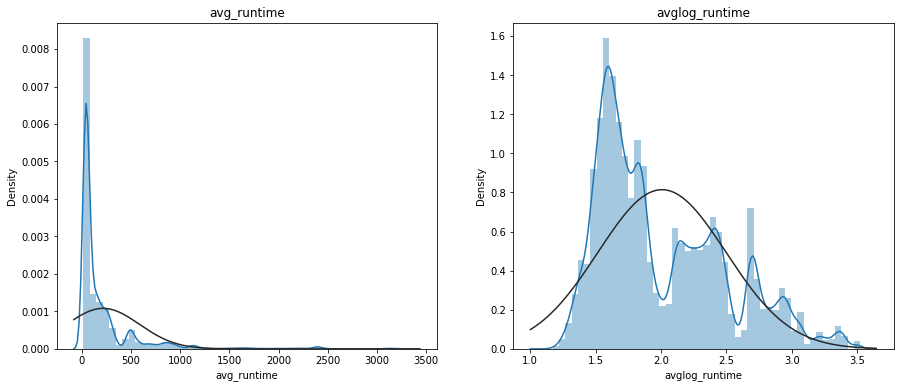

In [11]:
# Compare before and after distribution of dependent feature
from scipy.stats import norm

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
sns.distplot(df['avg_runtime'], fit=norm)
plt.title('avg_runtime')

plt.subplot(1, 2, 2)
sns.distplot(df['avglog_runtime'], fit=norm)
plt.title('avglog_runtime')
plt.show()

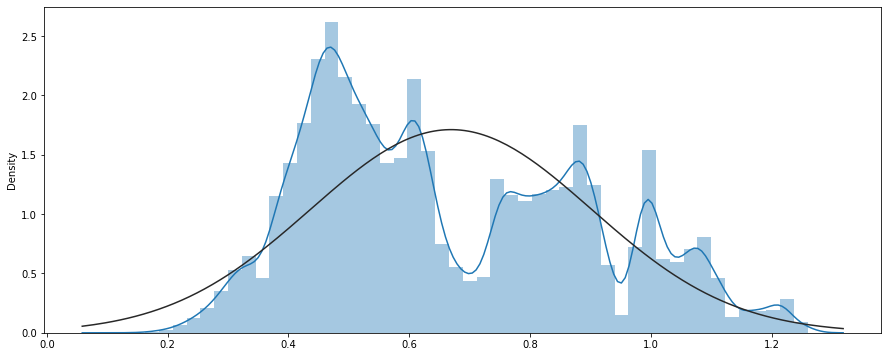

In [12]:
# Is the boxcox transformation better than Log Transformation for this case?
from scipy.stats import boxcox

plt.figure(figsize=(15,6))
# power transform
data=df['avglog_runtime']
data = boxcox(data, 0)
# histogram
sns.distplot(data, fit=norm)
plt.show()

In [13]:
# Drop the unnecessary column
df.drop('avg_runtime',axis=1,inplace=True)

## Check for Duplicated data 

In [14]:
df.duplicated().sum()

0



> The dataset has 0 duplicate rows




## Multicollinearity Check

In [18]:
# import variance_inflation_factor 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [19]:
# Create a function to return VIF value for that feature
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame() # create a DataFrame where we will add feature and its respective vif value
    vif["variables"] = X.columns # Variable feature in vif dataframe will have columns from X i.e. input
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] # vif value for that column 
    return(vif)

In [20]:
calc_vif(df[[i for i in df.describe().columns if i not in ['avglog_runtime']]])

,variables,VIF
0,MWG,5.570888
1,NWG,5.570888
2,KWG,9.434536
3,MDIMC,4.761904
4,NDIMC,4.761904
5,MDIMA,4.822777
6,NDIMB,4.822777
7,KWI,3.479154
8,VWM,3.097287
9,VWN,3.097287




> There is no severe multicollinearity in the independent features



# <b><u>Data Visualization 

In [21]:
# Build a function to get [box_plot and dist_plot for continuous values feature] and [box_plot and bar_plot for discrete plot]
def get_eda(df,dependent_feature):
  for col in df.columns:

    # Continuous features
    if len(df[col].unique())>20:
      plt.figure(figsize=(15,6))
      plt.subplot(1, 2, 1)
      fig = sns.boxplot(y=df[col])       # Box plot
      fig.set_title('',fontsize=17)
      fig.set_ylabel(col,fontsize=13)
      
      plt.subplot(1, 2, 2)
      fig = sns.distplot(df[col].dropna(),color='purple')  # Dist plot
      fig.set_ylabel('Frequency',fontsize=13)
      fig.set_xlabel(col,fontsize=13)
      plt.title(f'{col} Distribution',fontsize=17)
      plt.show()

    # Categorical features
    else:
      plt.figure(figsize=(15,6))
      plt.subplot(1, 2, 1)
      fig = sns.boxplot(df[col],df[dependent_feature])  # Box plot
      fig.set_title('')
      fig.set_ylabel(dependent_feature,fontsize=13)

      plt.subplot(1, 2, 2)
      counts = df[col].value_counts().sort_index()
      counts.plot.bar(color='steelblue')              # Bar plot
      plt.xlabel(col,fontsize=13)
      plt.ylabel('count',fontsize=13)
      plt.title(f'count of {col}',fontsize=17)
      plt.show()      

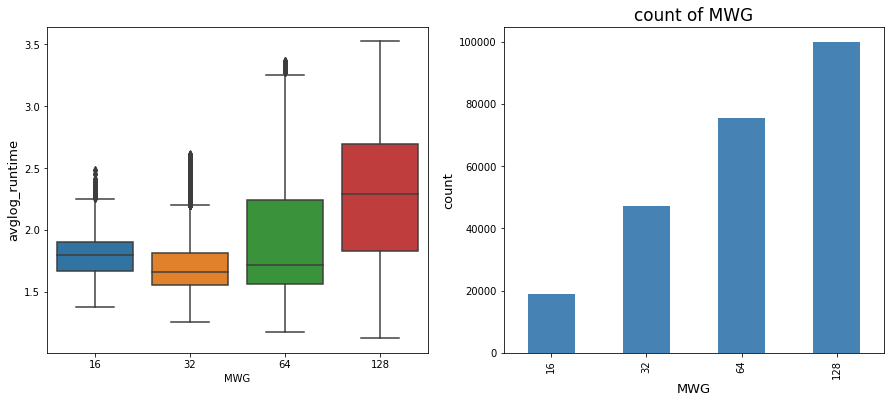

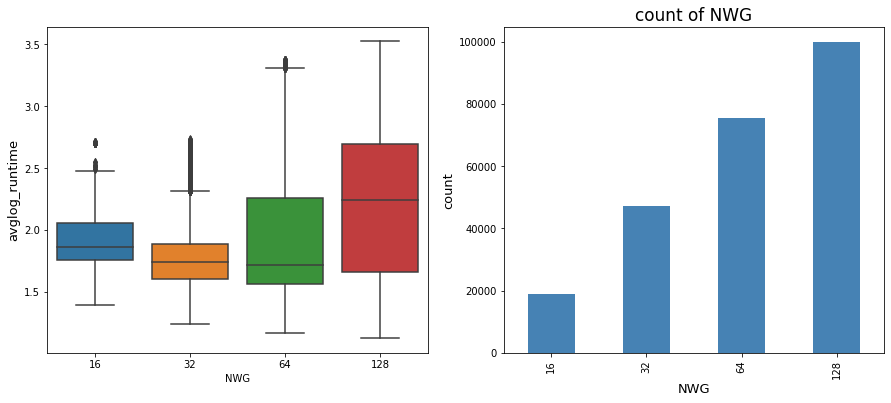

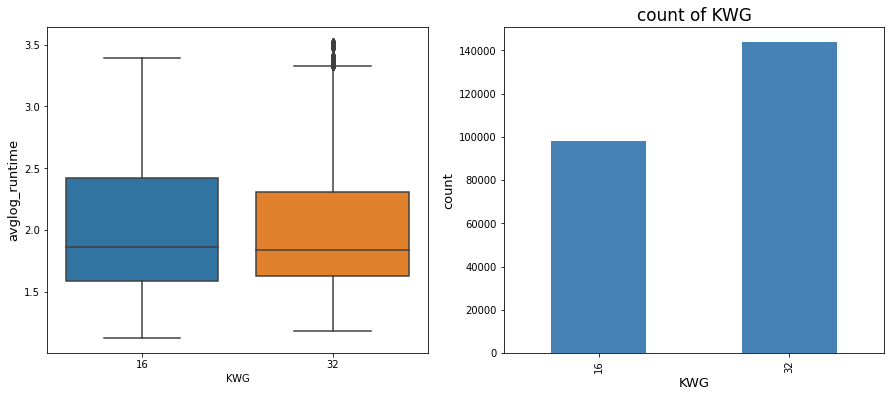

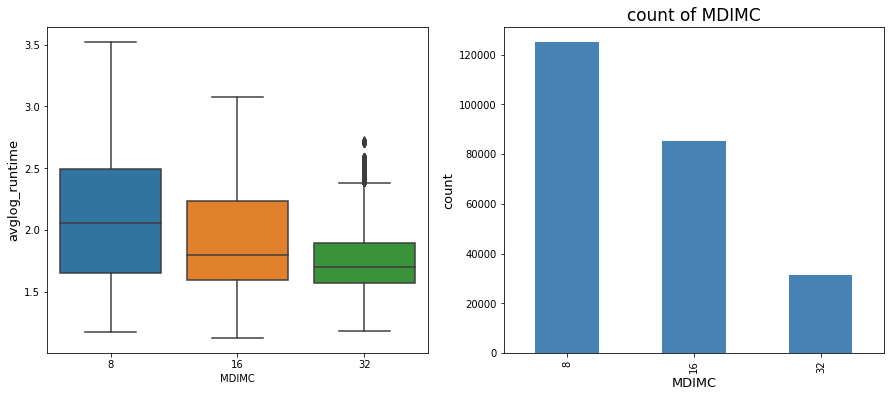

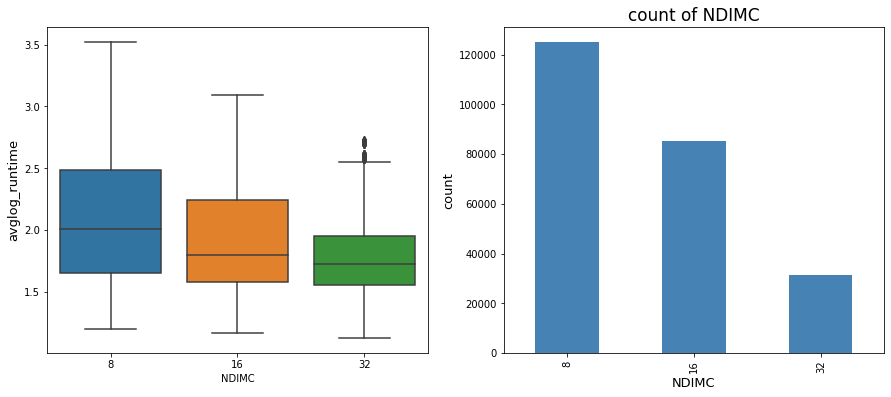

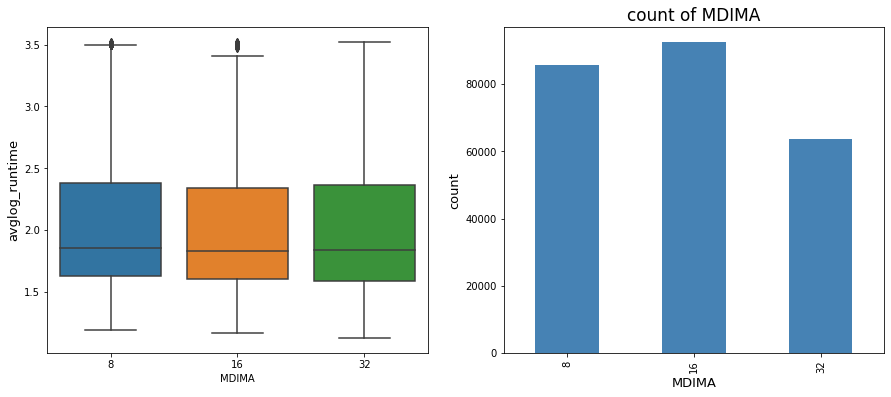

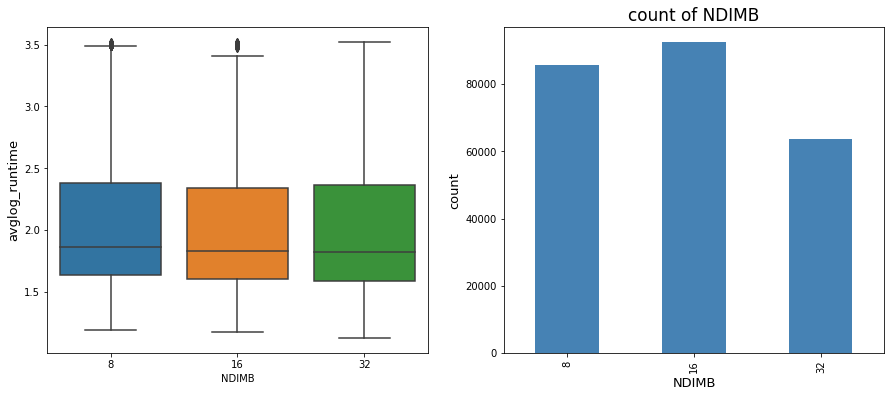

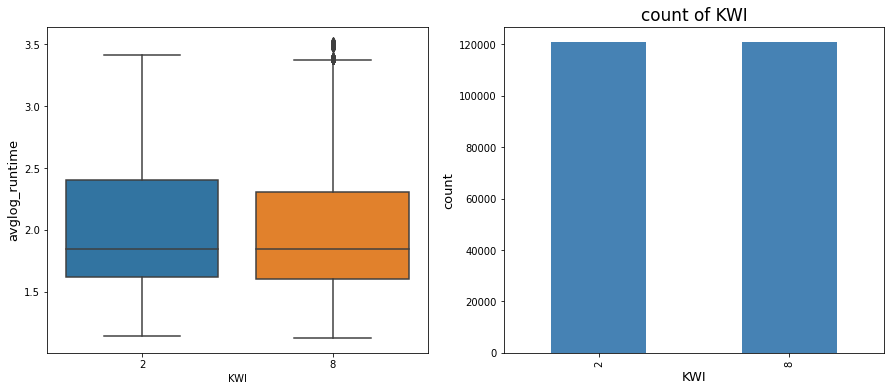

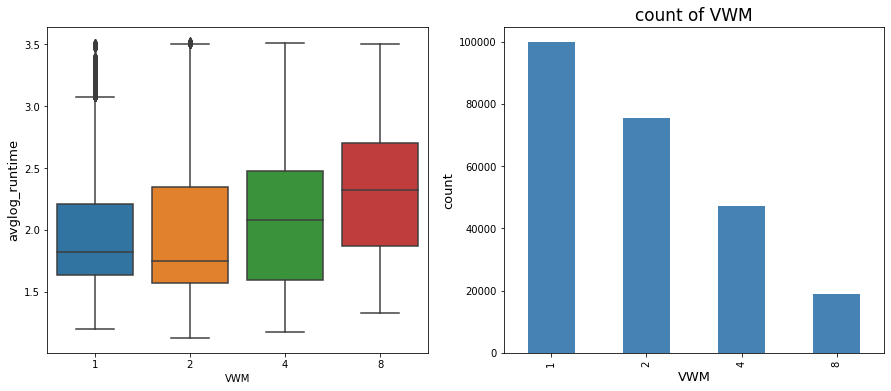

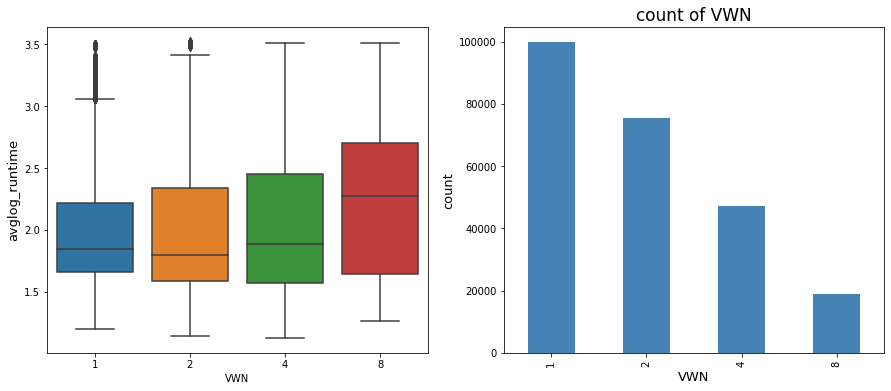

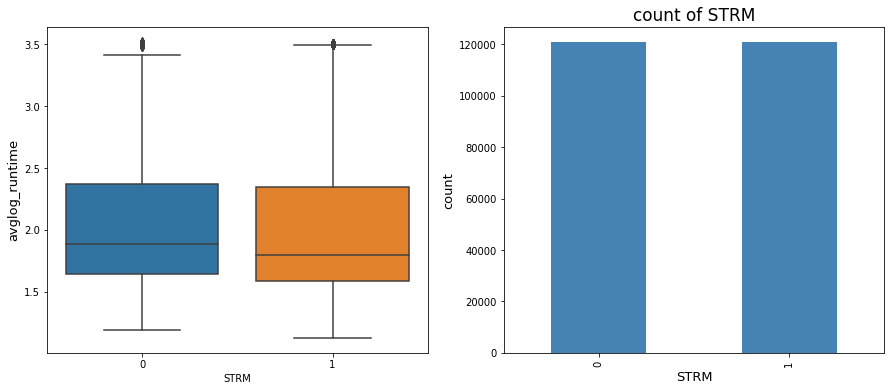

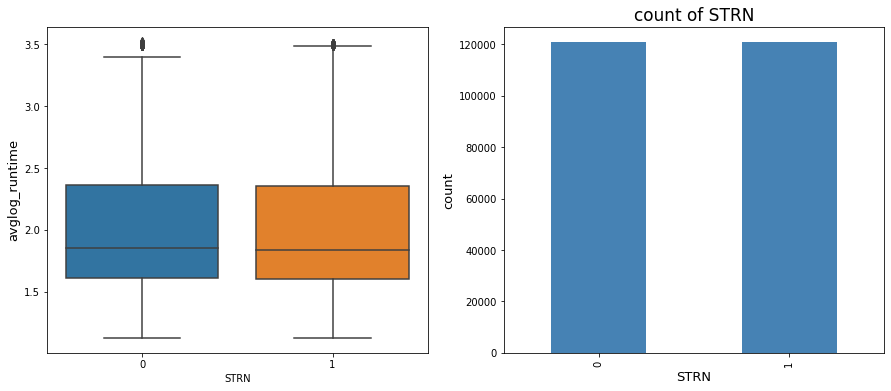

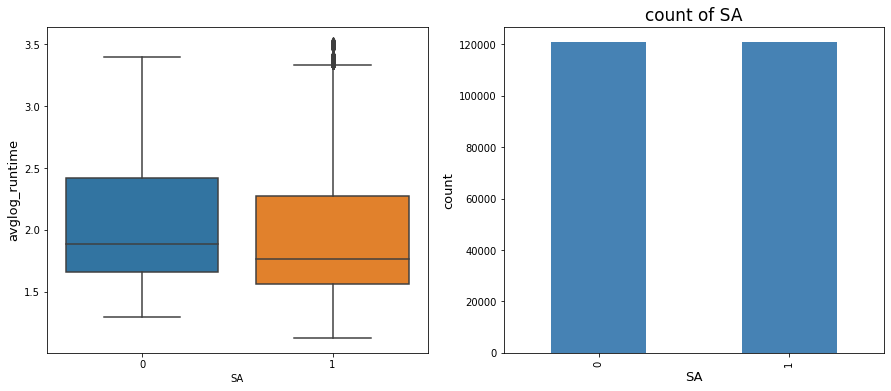

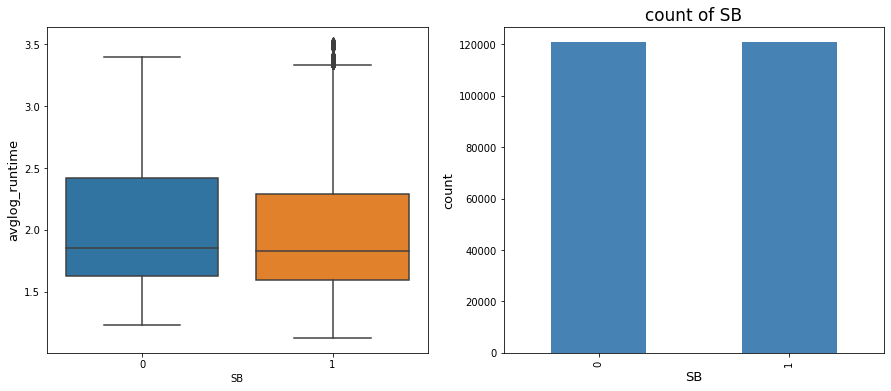

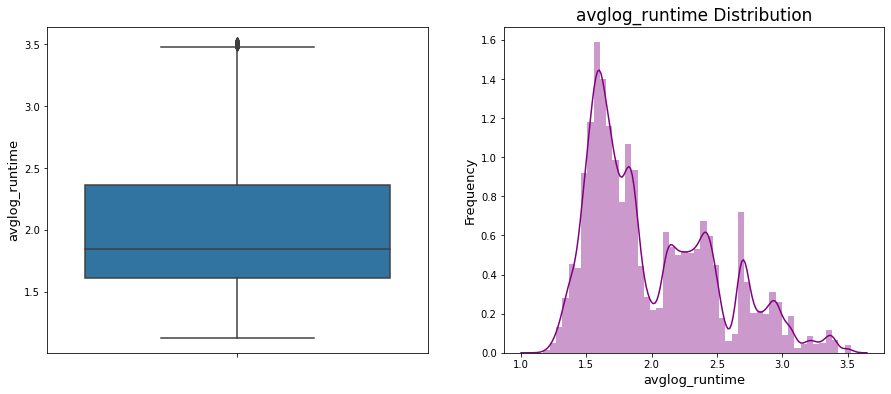

In [22]:
get_eda(df,'avglog_runtime')



> Data seems well balanced now



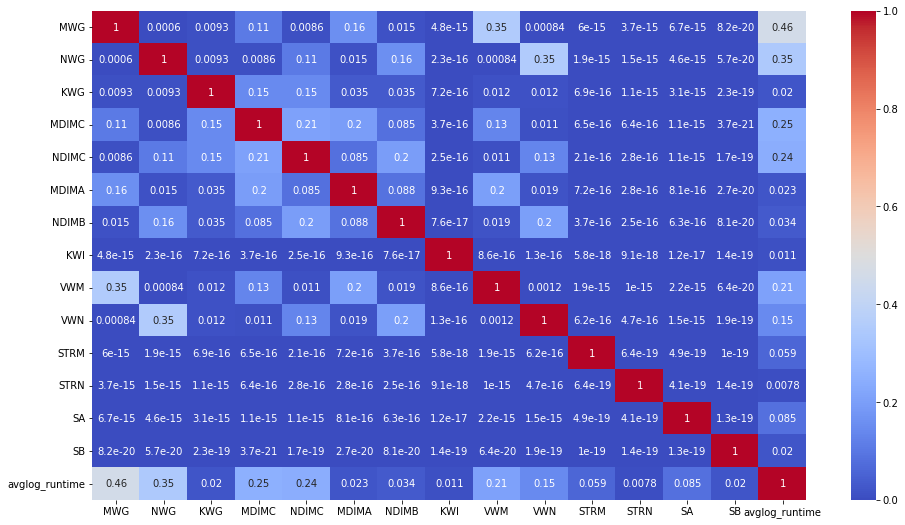

In [23]:
# Get the heatmap using seaborn.heatmap 
plt.figure(figsize=(16,9))
sns.heatmap(abs(df.corr()), annot=True, cmap='coolwarm')

# <b><u>Build ML Model

In [24]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]],df[df.columns[-1]],test_size = 0.2, random_state=0)

# Check the shape of train dataset
print(X_train.shape,y_train.shape)

# Check the shape of test dataset
print(X_test.shape, y_test.shape)

(193280, 14) (193280,)
(48320, 14) (48320,)


In [25]:
X_train.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
191440,128,64,32,16,8,16,16,2,2,1,0,0,0,0
77565,64,32,16,16,16,32,16,8,2,2,1,1,0,1
186804,128,64,32,8,16,16,32,8,4,2,0,1,0,0
155467,128,32,16,16,8,32,8,2,1,1,1,0,1,1
58929,32,128,32,8,32,8,8,8,1,1,0,0,0,1


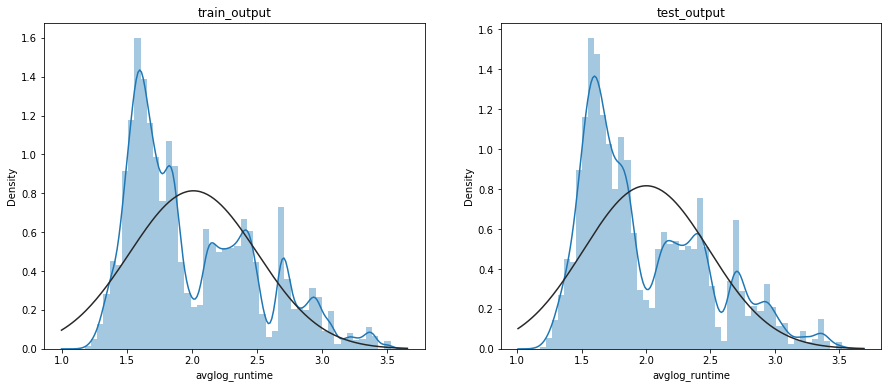

In [26]:
# Check the data distribution in train and test dataset
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
sns.distplot(y_train, fit=norm)
plt.title('train_output')

plt.subplot(1, 2, 2)
sns.distplot(y_test, fit=norm)
plt.title('test_output')
plt.show()

## Linear Regression model

Linear regression demands linear relation between dependent and independent features which is not present in most cases n such one case is here.

The regression works well with continuous features those are not present in this case.

Also, the feature should be uniformly distributed and features should be independet off each other.

In [27]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.5619267267667583

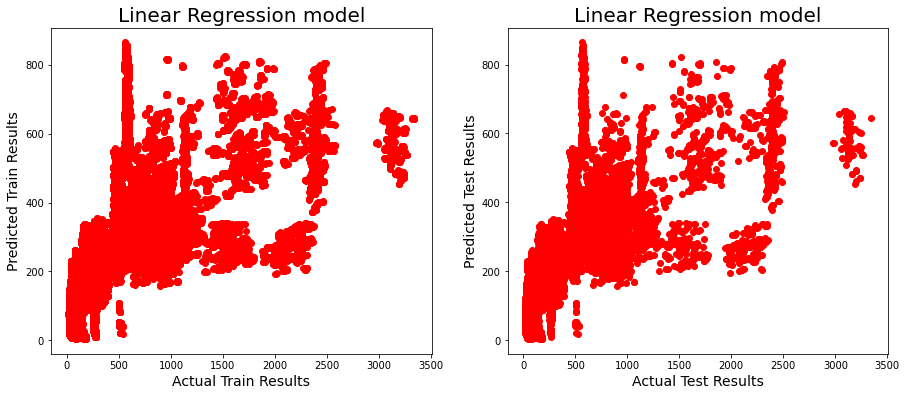

In [28]:
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

# Compare actual and predicted values of test data
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(np.array(10**(y_train)),10**(y_train_pred),c='red')
plt.xlabel('Actual Train Results',fontsize=14)
plt.ylabel('Predicted Train Results',fontsize=14)
plt.title('Linear Regression model',fontsize=20)

plt.subplot(1,2,2)
plt.scatter(np.array(10**(y_test)),10**(y_pred),c='red')
plt.xlabel('Actual Test Results',fontsize=14)
plt.ylabel('Predicted Test Results',fontsize=14)
plt.title('Linear Regression model',fontsize=20)
plt.show()



> Simple Linear regression model is a 'Poor predictor' for this case. Reasons are,

* All the independent features are of discrete nature, similar to categorical features. Linear regression works well with continuous features.
* Features have high variance, there are outliers in the dataset. But, none can be removed since all observations are unique.


Can it give a proper sense of feature importance atleast?


In [29]:
# View the coefficient values
coef = pd.DataFrame(list(zip(df.columns[:-1],reg.coef_)),columns=['Features','Coef'])
coef

,Features,Coef
0,MWG,0.005805
1,NWG,0.004582
2,KWG,0.005417
3,MDIMC,-0.024708
4,NDIMC,-0.023780
5,MDIMA,0.000074
6,NDIMB,-0.000040
7,KWI,-0.001602
8,VWM,-0.003902
9,VWN,-0.010476


We won't spend much time on trying to improve this model, it's hopeless!


## XGBoost model

Boosted Trees works good on regression models as well, they are the top choice of the data scientist due to their speed over Gradient boosted trees and overall performance. 

They can handle outliers and non-uniformly distributed features.
Hence, we directly opted for XGBoost.


In [30]:
from sklearn import ensemble
from xgboost import XGBRegressor

### Hit n run model
Calling it hit and run model because with max_depth value of 8 I got the train score in -ve. So it gave me some doubt.

So I took few chances with hits with max_depth=30, I wanted to test whether it is working or not?

#### Train the model

In [31]:
# Try the different parameters, fixing min_samples_split = 50 
xgb =  XGBRegressor (n_estimators= 100,max_depth= 22, min_samples_split= 50, learning_rate= 0.1,loss= 'neg_mean_squared_error') #Got the parameter by hit and run method

In [32]:
# Train the model
xgb.fit(X_train,y_train)

[17:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(loss='neg_mean_squared_error', max_depth=22, min_samples_split=50)

In [33]:
# Get Train score
xgb.score(X_train, y_train)

0.9999934140823729

> Looks like overfitting?
Check the Test score...

In [34]:
y_pred=xgb.predict(X_test)
y_train_pred = xgb.predict(X_train)

In [35]:
xgb.score(X_test, y_test)

0.9994963424196598



> Highly accurate performance, too early to comment?



#### Model performance

In [36]:
# Check the performance of the model using various metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MSE  = mean_squared_error(10**(y_test), 10**(y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 23.948820661038585
RMSE : 4.893753228457539
R2 : 0.9998225380235726
Adjusted R2 :  0.9998224865906429


> Showcase the results with visuals

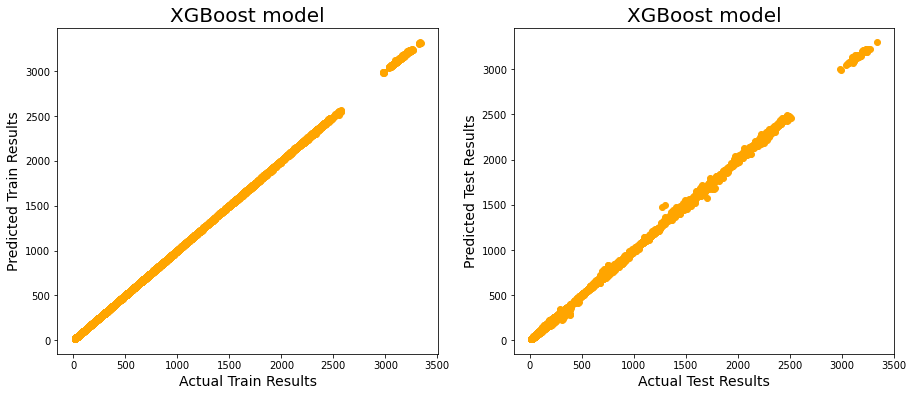

In [38]:
# Compare actual and predicted values of test data
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(np.array(10**(y_train)),10**(y_train_pred),c='orange')
plt.xlabel('Actual Train Results',fontsize=14)
plt.ylabel('Predicted Train Results',fontsize=14)
plt.title('XGBoost model',fontsize=20)

plt.subplot(1,2,2)
plt.scatter(np.array(10**(y_test)),10**(y_pred),c='orange')
plt.xlabel('Actual Test Results',fontsize=14)
plt.ylabel('Predicted Test Results',fontsize=14)
plt.title('XGBoost model',fontsize=20)
plt.show()

#### Model interpretation

> Get feature importances

Text(0.5, 1.0, 'Feature Importance (SGEMM GPU Kernel Performance)')

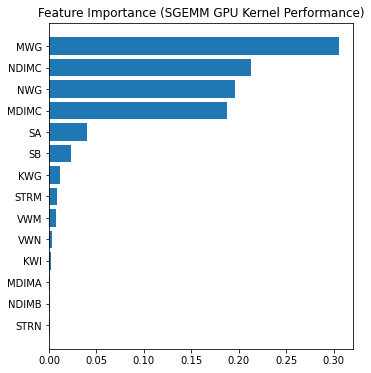

In [33]:
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (SGEMM GPU Kernel Performance)")

> <b> Use ELI5 to get weights for each feature


In [65]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.2 MB/s 


In [66]:
import eli5 as eli

In [41]:
eli.explain_weights(xgb)

Weight,Feature
0.3053,MWG
0.2133,NDIMC
0.1956,NWG
0.1874,MDIMC
0.0404,SA
0.0237,SB
0.0114,KWG
0.0085,STRM
0.0072,VWM
0.0036,VWN


> <b>Use shap to get feature impact and contribution in predicting the dependent feature

In [82]:
# Complex model will be interpreted with SHAP. Install shap 
!pip install shap

     |████████████████████████████████| 564 kB 8.4 MB/s 


In [83]:
import shap

In [36]:
X_test.shape

(48320, 14)

In [218]:
def get_summary_plot_BT(model_name,X_test,data_fraction):
  # DF, based on which importance is checked
  X_importance = X_test.sample(frac=data_fraction,random_state=0)

  # Explain model predictions using shap library (TreeExplainer is faster than KernalExplainer):
  explainer = shap.TreeExplainer(model_name)
  shap_values = explainer.shap_values(X_importance)

  # Plot summary_plot for Passed 
  shap.summary_plot(shap_values, X_importance)

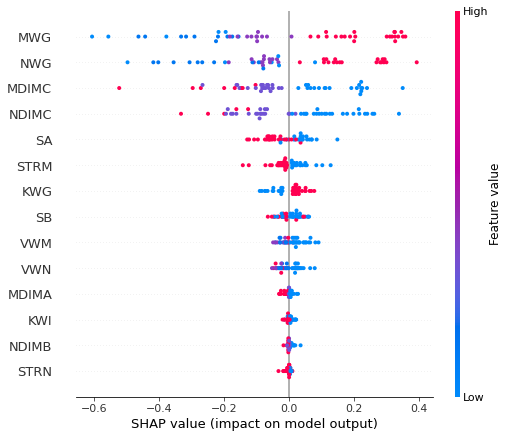

In [38]:
# Using a small sample size since the shap functions are pretty slow on the large dataset
get_summary_plot_BT(xgb,X_test,0.001)

For approximately 100 samples, it took 7 minutes.

We will spend our time on the optimal XGBoost model.



### Optimal model

The problem with the above model is that we ended up choosing high value for max_depth that generally creates overfitted model.

So, in optimal model we will see if lower max_depth value gives us more generalized results.

#### Find optimum values for parameter

In [39]:
# Since we need to select the best model in lesser time, we will be using BayesSeachCV
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.1 MB/s 


In [40]:
from skopt import BayesSearchCV

In [41]:
start = time. time()

# Create an instance of the RandomForestClassifier
xgb_model =  XGBRegressor (n_estimators= 100, learning_rate= 0.1,min_samples_split=50,loss= "squared_error")

# Bayes search
xgb_bayes= BayesSearchCV(estimator=xgb_model,
                       search_spaces = {'max_depth': (8,30)}, n_iter=5, cv = 3, verbose=2, scoring='neg_mean_squared_error',return_train_score=True)
# Fit the data
xgb_bayes.fit(X_train,y_train)

end = time. time()
print(f'Time taken to find optimal parameters using Bayes search is {(end - start)/60} minutes')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[03:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .......................................max_depth=27; total time= 1.3min
[03:04:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .......................................max_depth=27; total time= 1.3min
[03:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .......................................max_depth=27; total time= 1.2min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[03:07:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .......................................max_depth=17; total time=  57.8s
[03:08:04] WARNING: /workspace/src/objective/regre

In [42]:
# Get best parameters
xgb_bayes.best_estimator_

XGBRegressor(loss='squared_error', max_depth=18, min_samples_split=50)

In [43]:
xgb_optimal = xgb_bayes.best_estimator_

####Train the model

In [39]:
xgb_optimal =  XGBRegressor (n_estimators= 100,max_depth= 18, min_samples_split= 50, learning_rate= 0.1,loss= 'neg_mean_squared_error') 
xgb_optimal.fit(X_train,y_train)

[17:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(loss='neg_mean_squared_error', max_depth=18, min_samples_split=50)

In [40]:
xgb_optimal.score(X_train,y_train),xgb_optimal.score(X_test,y_test)

(0.999955895700659, 0.9994919233128617)

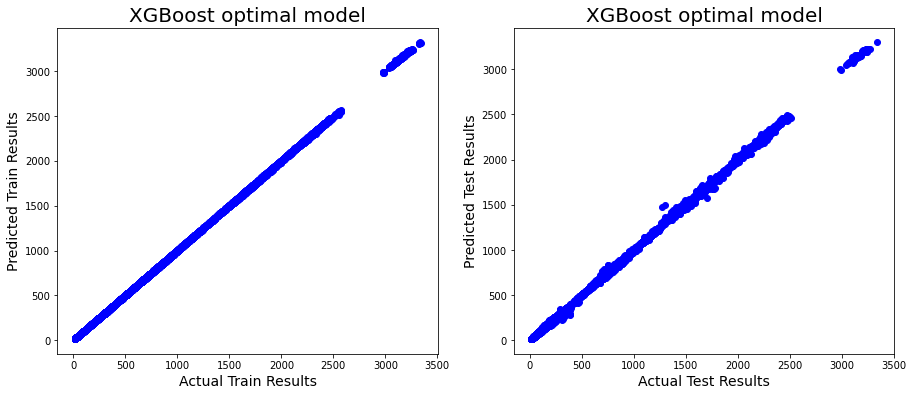

In [41]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(np.array(10**(y_train)),10**(y_train_pred),c='blue')
plt.xlabel('Actual Train Results',fontsize=14)
plt.ylabel('Predicted Train Results',fontsize=14)
plt.title('XGBoost optimal model',fontsize=20)

plt.subplot(1,2,2)
plt.scatter(np.array(10**(y_test)),10**(y_pred),c='blue')
plt.xlabel('Actual Test Results',fontsize=14)
plt.ylabel('Predicted Test Results',fontsize=14)
plt.title('XGBoost optimal model',fontsize=20)
plt.show()

#### Model Interpretation

Text(0.5, 1.0, 'Feature Importance (SGEMM GPU Kernel Performance)')

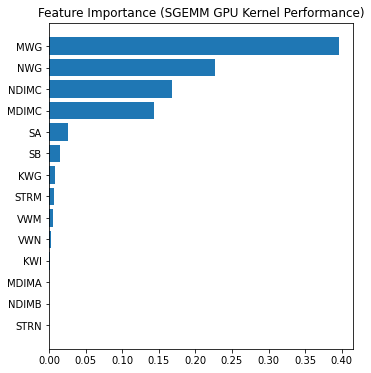

In [34]:
feature_importance = xgb_optimal.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (SGEMM GPU Kernel Performance)")

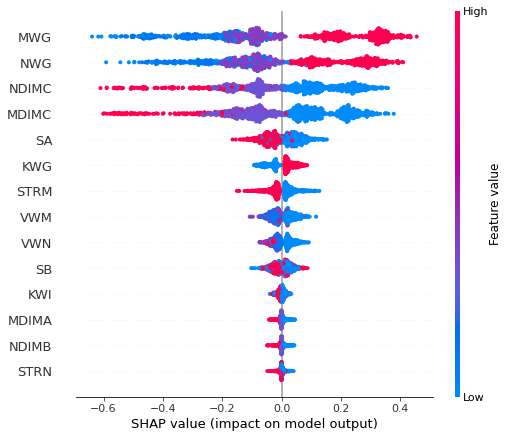

In [220]:
get_summary_plot_BT(xgb_optimal,X_test,0.02) # Sampling about 1000 rows from X_test. This step took an hour approx. to get the results.

In [221]:
eli.explain_weights(xgb_optimal)

Weight,Feature
0.3959,MWG
0.2271,NWG
0.1676,NDIMC
0.1433,MDIMC
0.0257,SA
0.0149,SB
0.0086,KWG
0.0066,STRM
0.0053,VWM
0.0027,VWN


The following conclusions can be made about the features,

* MWG, NWG: per-matrix 2D tiling at workgroup level and MDIMC, NDIMC: local workgroup size, together contributes 90% in predicting the runtime (Inference from all the three charts, mainly ELI5).

* MWG, NWG contributes positively while MDIMC, NDIMC contributes negatively (Inference from shap summary plot).

* KWI: kernel loop unrolling factor, MDIMA, NDIMB: local memory shape and STRN: enable stride for accessing off-chip memory within a single thread, have minimal impact on the runtime.

* Rest features have slight impact on runtime


In [233]:
10**(df[(df['MWG']<60) & (df['NWG']<60)]['avglog_runtime']).describe()

count           inf
mean      60.041752
std        1.472960
min       20.810000
25%       45.469375
50%       58.546250
75%       75.780000
max      183.980000
Name: avglog_runtime, dtype: float64

In [232]:
10**(df[(df['MWG']>60) & (df['NWG']>60)]['avglog_runtime']).describe()

count            inf
mean      161.831796
std         3.603966
min        13.317500
25%        43.021250
50%       186.018750
75%       479.033125
max      3341.507500
Name: avglog_runtime, dtype: float64

Did you observe the impact of MWG, NMG: per-matrix 2D tiling at workgroup level ?

## Neural Network model

They are considered as top of the line performers having ability to solve any problem. But, I don't have much grasp on neural networks yet.

The basic neural network model can be built using Keras from Tensorflow
The basic model anatomy shows the input layer, hidden layers and activation functions.

The optimal blend of right parameters can do make a wonderful model. Remember that, the neural network models are highly prone to overfitting. 

It takes a large amount of time to build a optimal Neural network model.

In [42]:
# Use keras coz only that library I am aware of
import tensorflow
import keras

### Single hidden layer model with cross validation

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers

# define a function to build the keras model
def simpleNN_model():
  # create model
  model = Sequential()
  model.add(Dense(20, input_dim=X_test.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
  
  # compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [66]:
keras_simple_NN = simpleNN_model()

In [67]:
checkpoint = keras.callbacks.ModelCheckpoint("_runtime.h5", save_best_only=False)

In [68]:
# We have a large dataset here, so choosing batch_size of 15 with 30 epoch
history1= keras_simple_NN .fit(
    X_train, y_train,
    epochs=30,
    batch_size=15,
    validation_split=0.2,
    callbacks=[checkpoint]
)

Epoch 1/30
10309/10309 [==============================] - 17s 2ms/step - loss: 0.0565 - val_loss: 0.0326
Epoch 2/30
10309/10309 [==============================] - 32s 3ms/step - loss: 0.0338 - val_loss: 0.0313
Epoch 3/30
10309/10309 [==============================] - 31s 3ms/step - loss: 0.0309 - val_loss: 0.0281
Epoch 4/30
10309/10309 [==============================] - 21s 2ms/step - loss: 0.0282 - val_loss: 0.0273
Epoch 5/30
10309/10309 [==============================] - 30s 3ms/step - loss: 0.0219 - val_loss: 0.0160
Epoch 6/30
10309/10309 [==============================] - 23s 2ms/step - loss: 0.0173 - val_loss: 0.0157
Epoch 7/30
10309/10309 [==============================] - 16s 2ms/step - loss: 0.0165 - val_loss: 0.0182
Epoch 8/30
10309/10309 [==============================] - 16s 2ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 9/30
10309/10309 [==============================] - 24s 2ms/step - loss: 0.0159 - val_loss: 0.0172
Epoch 10/30
10309/10309 [==============================

In [69]:
history1

In [70]:
# Create a model_history dataframe
simple_model_history = pd.DataFrame(history1.history)
simple_model_history['epoch'] = history1.epoch

In [71]:
simple_model_history

,loss,val_loss,epoch
0,0.056463,0.032557,0
1,0.033782,0.031310,1
2,0.030913,0.028113,2
3,0.028188,0.027254,3
4,0.021922,0.015983,4
5,0.017274,0.015686,5
6,0.016476,0.018244,6
7,0.016158,0.016213,7
8,0.015933,0.017223,8
9,0.015637,0.014528,9


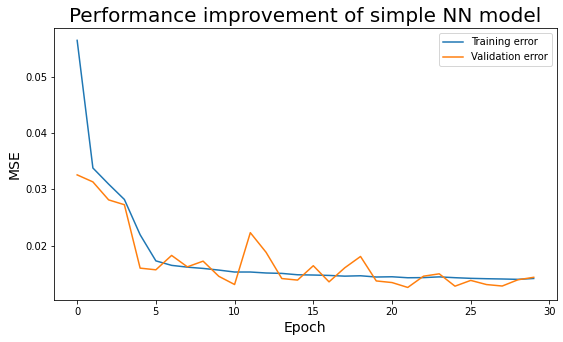

In [72]:
# Plot the iteration history
fig, ax = plt.subplots(1, figsize=(9,5))
num_epochs = simple_model_history.shape[0]

ax.plot(np.arange(0, num_epochs), simple_model_history["loss"], 
        label="Training error")
ax.plot(np.arange(0, num_epochs), simple_model_history["val_loss"], 
        label="Validation error")
ax.legend()
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.title('Performance improvement of simple NN model',fontsize=20)
plt.show()

In [73]:
#make predictions
y_pred = keras_simple_NN.predict(X_test)     
y_train_pred = keras_simple_NN.predict(X_train) 

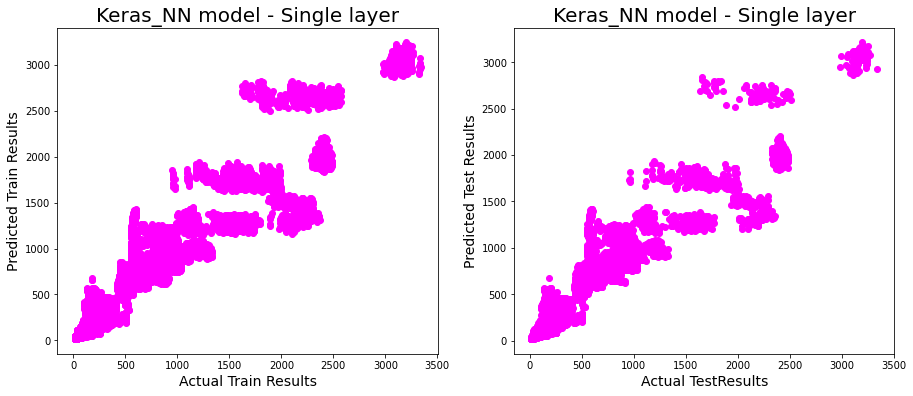

In [76]:
# Compare actual and predicted values of test data
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(np.array(10**(y_train)),10**(y_train_pred),c='magenta')
plt.xlabel('Actual Train Results',fontsize=14)
plt.ylabel('Predicted Train Results',fontsize=14)
plt.title('Keras_NN model - Single layer',fontsize=20)

plt.subplot(1,2,2)
plt.scatter(np.array(10**(y_test)),10**(y_pred),c='magenta')
plt.xlabel('Actual TestResults',fontsize=14)
plt.ylabel('Predicted Test Results',fontsize=14)
plt.title('Keras_NN model - Single layer',fontsize=20)
plt.show()

In [75]:
# Check the performance of the model using various metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MSE  = mean_squared_error(10**(y_test), 10**(y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 11398.60353417622
RMSE : 106.76424276964747
R2 : 0.9155357693676134
Adjusted R2 :  0.915511289516069


### Multi layer model

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers

# define a function to build the keras model
def NN_model():
    # create model
    model = Sequential([
                        keras.layers.Flatten(input_shape=[X_train.shape[-1]]),
                        keras.layers.Dense(64, input_dim=X_test.shape[1], kernel_initializer='normal',  activation='relu'),
                        keras.layers.Dense(32, activation='relu'),                   
                        keras.layers.Dense(8, activation='relu'),
                        keras.layers.Dense(1, activation='linear')
                        ])
    
    # compile model
    opt = Adam(lr=1e-3)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [44]:
keras_NN = NN_model()

In [45]:
checkpoint = keras.callbacks.ModelCheckpoint("runtime.h5", save_best_only=False)

In [46]:
# We have a large dataset here, so choosing batch_size of 15 with 30 epoch
history= keras_NN .fit(
    X_train, y_train,
    epochs=30,
    batch_size=15,
    validation_split=0.2,
    callbacks=[checkpoint]
)

Epoch 1/30
10309/10309 [==============================] - 20s 2ms/step - loss: 0.0368 - val_loss: 0.0128
Epoch 2/30
10309/10309 [==============================] - 19s 2ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 3/30
10309/10309 [==============================] - 22s 2ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 4/30
10309/10309 [==============================] - 19s 2ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 5/30
10309/10309 [==============================] - 19s 2ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 6/30
10309/10309 [==============================] - 19s 2ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 7/30
10309/10309 [==============================] - 19s 2ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 8/30
10309/10309 [==============================] - 19s 2ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 9/30
10309/10309 [==============================] - 19s 2ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 10/30
10309/10309 [==============================

In [47]:
history

In [48]:
# Create a model_history dataframe
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

In [49]:
model_history

,loss,val_loss,epoch
0,0.036829,0.012767,0
1,0.011551,0.010800,1
2,0.008215,0.006586,2
3,0.006484,0.005007,3
4,0.005510,0.005656,4
5,0.004902,0.003922,5
6,0.004439,0.004477,6
7,0.004181,0.004663,7
8,0.003929,0.003037,8
9,0.003730,0.005140,9


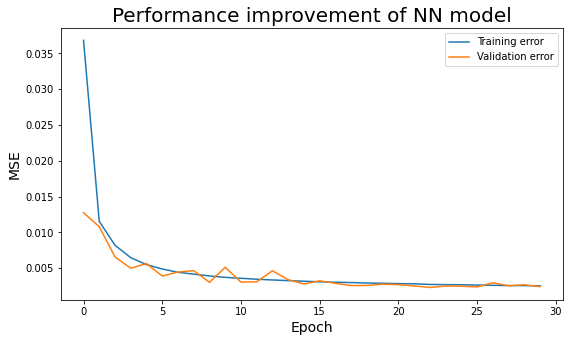

In [50]:
# Plot the iteration history
fig, ax = plt.subplots(1, figsize=(9,5))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["loss"], 
        label="Training error")
ax.plot(np.arange(0, num_epochs), model_history["val_loss"], 
        label="Validation error")
ax.legend()
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.title('Performance improvement of NN model',fontsize=20)
plt.show()

In [78]:
#make predictions
y_pred = keras_NN.predict(X_test)     
y_train_pred = keras_NN.predict(X_train) 

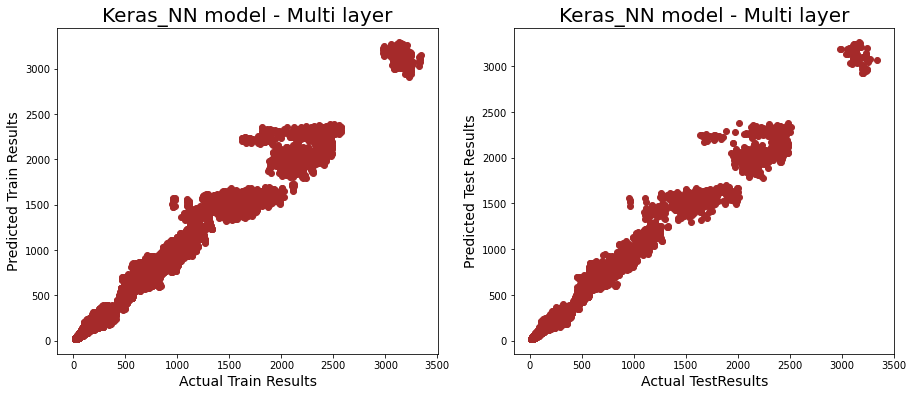

In [79]:
# Compare actual and predicted values of test data
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(np.array(10**(y_train)),10**(y_train_pred),c='brown')
plt.xlabel('Actual Train Results',fontsize=14)
plt.ylabel('Predicted Train Results',fontsize=14)
plt.title('Keras_NN model - Multi layer',fontsize=20)

plt.subplot(1,2,2)
plt.scatter(np.array(10**(y_test)),10**(y_pred),c='brown')
plt.xlabel('Actual TestResults',fontsize=14)
plt.ylabel('Predicted Test Results',fontsize=14)
plt.title('Keras_NN model - Multi layer',fontsize=20)
plt.show()

In [54]:
# Check the performance of the model using various metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MSE  = mean_squared_error(10**(y_test), 10**(y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1509.1871806227423
RMSE : 38.84825839883614
R2 : 0.9888168464049686
Adjusted R2 :  0.9888136052466966


In [98]:
# select backgroud for shap
background = X_train.sample(frac =0.002)# DeepExplainer to explain predictions of the model
explainer = shap.KernelExplainer(keras_NN, background)# compute shap values
shap_values = explainer.shap_values(X_test.iloc[:1000])

Using 387 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

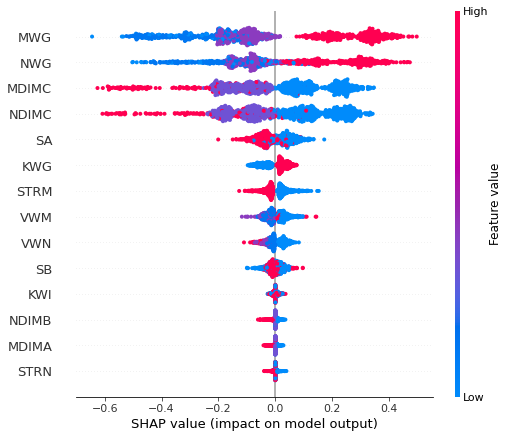

In [100]:
# Plot summary_plot for Passed 
shap.summary_plot(shap_values[0], X_test.iloc[:1000])

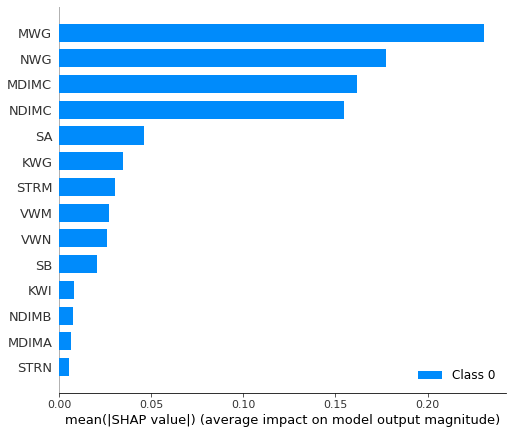

In [103]:
# Plot summary_plot for Passed 
shap.summary_plot(shap_values, X_test.iloc[:1000])

# <b><u>Model Comparison based on performance

In [63]:
# Get the accuracy score for the model
def models_comparison(model_list,model_name_list,X_train,X_test,y_train,y_test):
  # Will need these libraries
  from sklearn.metrics import mean_squared_error as MSE
  from sklearn.metrics import r2_score as R2

  # Initialize the variables
  _MSE_, _R2_  = [],[]
  for model_name in model_list:
    # Get the predicted classes
    train_class_preds = model_name.predict(X_train)
    test_class_preds = model_name.predict(X_test)

    # Get test scores
    _MSE_.append((round(MSE(y_train,train_class_preds),2) ,round(MSE(y_test, test_class_preds),2)))
    _R2_.append((round(R2(y_train,train_class_preds)*100,3),round(R2(y_test, test_class_preds)*100,3)))

  # Prepare a metric dataframe
  model_comparison = pd.DataFrame(list(zip(model_name_list,_MSE_, _R2_ )), columns = ['Model_Name','Mean Square Error','R_square'])
  return model_comparison 

In [64]:
model_list = [reg,xgb_optimal,keras_NN]
model_name_list = ['Linear regression model','XGBoost model', 'Keras - Neural Network model']

In [65]:
models_comparison(model_list, model_name_list, X_train, X_test, y_train, y_test)

,Model_Name,Mean Square Error,R_square
0,Linear regression model,"(0.11, 0.11)","(56.193, 55.824)"
1,XGBoost model,"(0.0, 0.0)","(99.996, 99.949)"
2,Keras - Neural Network model,"(0.0, 0.0)","(99.004, 98.969)"


## **From above table, we can conclude that XG boosted model is far superior than the other models.** 
#### 'Logistic regression model' takes least amount of time n the model is easily interpretable but has some assumptions. Not good for real world scenarios.
#### 'Random forest model' took more building time n improved the precision but overall it gave almost same results as logistic regression model did. Also had to use SHAP explainer. It would have been better to invest all that time in XGboosted model.
#### 'Gradient boosted trees model' and 'XG boosted tress model' takes considerably large amount of time when compared to logistic regression model.
#### In this study we used BayesSearchCV based on the results from guided project. One may use RandomSeachCV if they want to save time, the result sometimes may surprise you :).



## **Understand the model using summary plot**
#### Important features to make a prediction are given in following figure. The features are presented in decreasing order of their importance i.e. top feature 'BMI' contributes most in predicting the output response of Insurance decision and its most valuable in most cases.

#### The correlation of the features with the dependent feature can be understood by the domination on right side of 0 on impact axis (X-axis). If most points are blue, like in 'BMI' or 'Wt' then that faeture is negatively correlated with dependent feature. The bulb of red points in case of 'Medical_History_4' feature suggests that it is positively correlated with the dependent feature.

#### The distribution of each feature can also be related. The 'BMI' feature is highly +vely skewed while 'Medical_History_4' feature is -vely skewed but not as skewed as 'BMI' is. 'Ins_Age' and'Family_Hist_3' is uniformly distributed. 

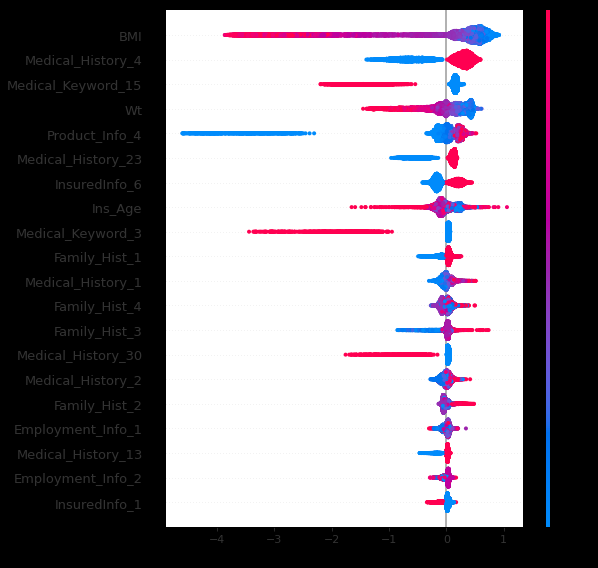